# Make image prediction

Usually, we run the model on entire datasets to compare its predictions to the ground-truths and so determine its performance. However, sometimes it is interesting to see what a model predicts on some random manually provided image. In this notebook, you can provide any image you like, specify which model to use, and observe the prediction. This notebook can be run as either cuda or CPU.

Let's start by going to the main directory of the project and import some libraries.

In [1]:
%cd ..

C:\Users\Wight\PycharmProjects\ViCCT


In [2]:
import numpy as np
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm

from PIL import Image
import models.ViCCT_models
import models.Swin_ViCCT_models
from timm.models import create_model

from datasets.dataset_utils import img_equal_split, img_equal_unsplit
import torchvision.transforms as standard_transforms

## Parameters

Several parameters need to be defined to run the notebook. The cell below is the only cell that needs modification in this notebook.

In [205]:
# First, which model will we use? The generic ViCCT version 1 model is specified with 'ViCCT_base'. The version 2 ViCCT model,
# which has Swin as its base, is specified with 'Swin_ViCCT_large_22k'.
# model_name = 'ViCCT_base'
model_name = 'Swin_ViCCT_large_22k'

# The model is trained to perform crowd counting. We specify here where the weights of this trained model is located.
# weights_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\trained_models\\ViCCT base most public\\save_state_ep_1300.pth'
weights_path = 'D:\\OneDrive\\OneDrive - UvA\\ThesisData\\trained_models\\SWIN generic\\save_state_ep_1600.pth'

# Now, for which image will the model make a prediction? We now specify where the image is located.
image_path = 'D:\\Bureaublad\\0480.jpg'

# Some images are of extremely large resolution. When the heads in images occupy many (e.g. something like 100 x 100 
# pixels each) pixels, the model is unable to make pretty predictions. One way to overcome this issue is to scale the image
# by some factor. This factory is specified here. A factor of 1. means no scaling is performed.
scale_factor = 1.

# We might want to save the predictions. Set 'save_results' to true if you want to save the prediction. Both the input to
# the model and the prediction are saved in the folder 'try_image_result'
save_results = True

# Lastly, do we use cuda? If you have cuda, it's advised to use it.
use_cuda = True

## Some variables used later. No need to modify these!

In [206]:
# Only for hardcore users. No need to modify these.
mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Mean and std.dev. of ImageNet
overlap = 32  # We ensure crops have at least this many pixels of overlap.
ignore_buffer = 16  # When reconsturting the whole density map, ignore this many pixels on crop prediction borders.

train_img_transform = standard_transforms.Compose([
    standard_transforms.ToTensor(),
    standard_transforms.Normalize(*mean_std)
])

## Functions to load the model and input image

In [207]:
def get_model(model_name, weights_path, use_cuda):
    """ Creates the model and initialised it with the weights specified. """
    model = create_model(  # From the timm library. This function created the model specific architecture.
    model_name,
    init_path=weights_path,
    pretrained_cc=True,
    drop_rate=None if 'Swin' in model_name else 0.,  # Dropout

    # Bamboozled by Facebook. This isn't drop_path_rate, but rather 'drop_connect'.
    # I'm not yet sure what it is for the Swin version
    drop_path_rate=None if 'Swin' in model_name else 0.,
    drop_block_rate=None,  # Drops our entire Transformer blocks I think? Not used for ViCCT.
    )

    if use_cuda:
        model = model.cuda()  # Place model on GPU
    
    model = model.eval()
    
    return model

def get_image(image_path, scale_factor):
    """ Loads the image from disk. Scaled the image if specified. """
    
    img = Image.open(image_path).convert('RGB')
    if scale_factor != 1.:
        w, h = img.size
        new_w, new_h = round(w * scale_factor), round(h * scale_factor)
        img = img.resize((new_w, new_h))
    
    return img

## Get the model and image. Next, make a prediction!

In [208]:
# Get the model
print('Making the model...')
model = get_model(model_name, weights_path, use_cuda)

# Get the image
print('Loading the image...')
input_image = get_image(image_path, scale_factor)
img = input_image.copy()  # Make a copy so we don't alter the original
img_w, img_h = img.size

# Before we make the prediction, we normalise the image and split it up into crops
print('Preparing image...')
img = train_img_transform(img)
img_stack = img_equal_split(img, 224, overlap)  # Split the image ensuring a minimum of 'overlap' of overlap between crops.

if use_cuda:
    img_stack = img_stack.cuda()  # Place image stack on GPU        
    
# This is the placeholder where we store the model predictions.
pred_stack = torch.zeros(img_stack.shape[0], 1, 224, 224)

print('Making prediction now...')
if not use_cuda and img_stack.shape[0] > 100:  # If on CPU and more than 100 image crops.
    print('\033[93m'
          'WARNING: you are making a prediction on the CPU but provided a large image. This might take a'
          ' (very) long time! You might want to consider downsizing the image with "scale_factor".'
          '\033[0m')

with torch.no_grad():  # Dont make gradients
    for idx, img_crop in enumerate(tqdm(img_stack)):  # For each image crop
        pred_stack[idx] = model.forward(img_crop.unsqueeze(0)).cpu()  # Make prediction.
print('Done!')


# Unsplit the perdiction crops to get the entire density map of the image.
den = img_equal_unsplit(pred_stack, overlap, ignore_buffer, img_h, img_w, 1)
den = den.squeeze()  # Remove the channel dimension

# Compute the perdicted count, which is the sum of the entire density map. Notice that the model is trained with density maps
# scaled by a factor of 3000 (See sec 5.2 of my thesis for why: https://scripties.uba.uva.nl/search?id=723178). In short,
# This works :)
pred_cnt = den.sum() / 3000

Making the model...
Loading the image...
Preparing image...
Making prediction now...


  0%|          | 0/336 [00:00<?, ?it/s]

Done!


## We now display the results and save them if save_results is set to True

In [209]:
def save_result_func(image_path, input_image, prediction, predicted_count, overlayed):
    """ Saves the results in the 'try_image_result' directory. Makes the directory if it doesn't exist. """
    
    # We save results here
    save_dir = 'try_image_result'
    
    # Make dir if not exists
    if not os.path.exists(save_dir):  
        os.mkdir(save_dir)
        
    # Extract just the filename from image path
    full_name = os.path.basename(image_path)
    file_name = os.path.splitext(full_name)[0]
    
    # The paths where to save the results
    input_save_name = file_name + '_input' + '.jpg'
    img_save_path = os.path.join(save_dir, input_save_name)
    predicion_save_name = file_name + '_prediction' + '.jpg'
    pred_save_path = os.path.join(save_dir, predicion_save_name)
    overlayed_save_name = file_name + '_overlayed' + '.jpg'
    overlayed_save_path = os.path.join(save_dir, overlayed_save_name)

    
    # Save results
    fig = plt.figure(figsize=(1920/200, 1080/200), dpi=200)
    plt.imshow(input_image, cmap=cm.jet)
    plt.title(f'Input image for the network')
    plt.savefig(img_save_path, dpi=200, bbox_inches='tight')
    plt.close(fig)
    
    fig = plt.figure(figsize=(1920/200, 1080/200), dpi=200)
    plt.imshow(prediction, cmap=cm.jet)
    plt.title(f'predicted count = {predicted_count:.3f}')
    plt.savefig(pred_save_path, dpi=200, bbox_inches='tight')
    plt.close(fig)
    
    fig = plt.figure(figsize=(1920/200, 1080/200), dpi=200)
    plt.imshow(overlayed, cmap=cm.jet)
    plt.title(f'predicted count = {predicted_count:.3f}')
    plt.savefig(overlayed_save_path, dpi=200, bbox_inches='tight')
    plt.close(fig)

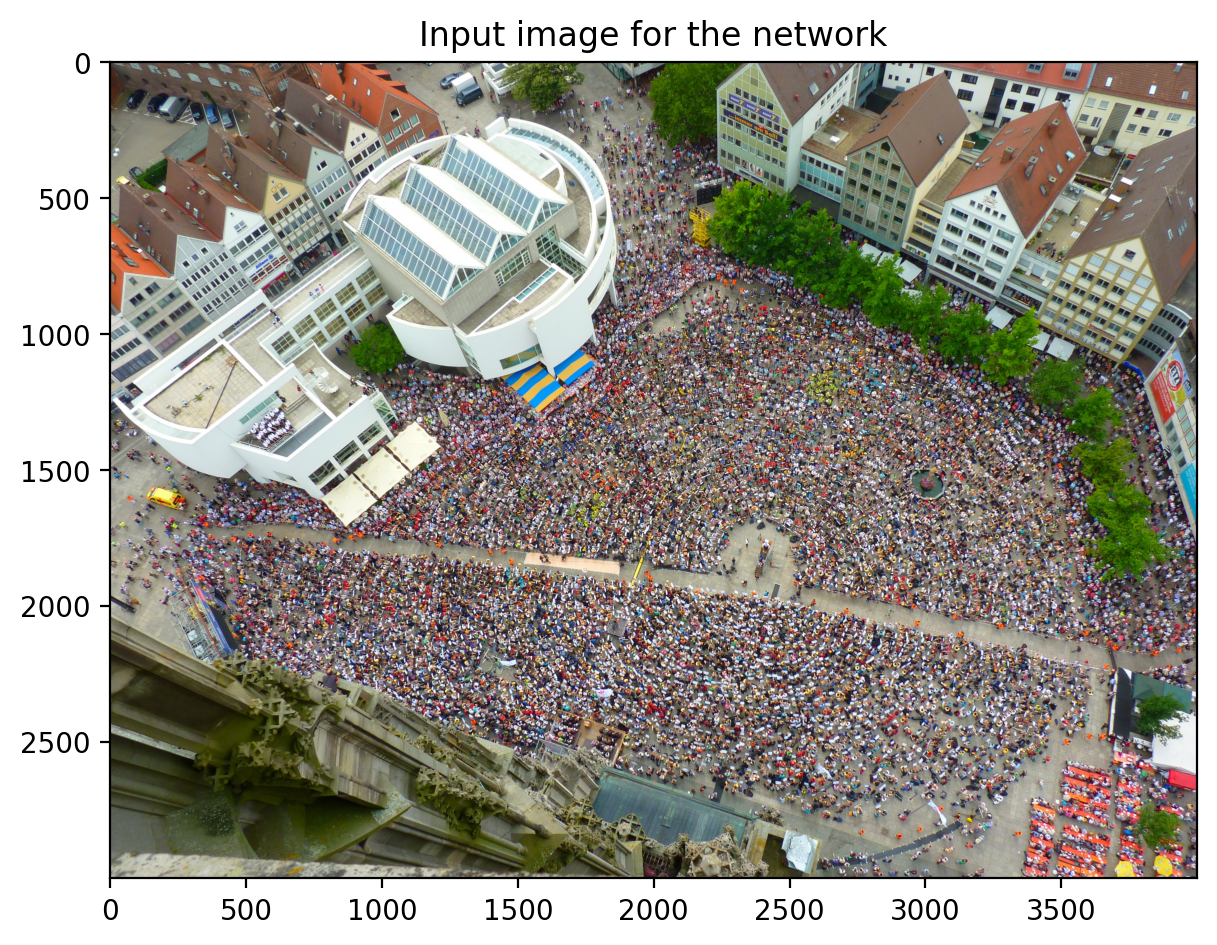

In [210]:
# Show input image
plt.figure(figsize=(1920/200, 1080/200), dpi=200)
plt.imshow(input_image, cmap=cm.jet)
plt.title(f'Input image for the network')
plt.show()

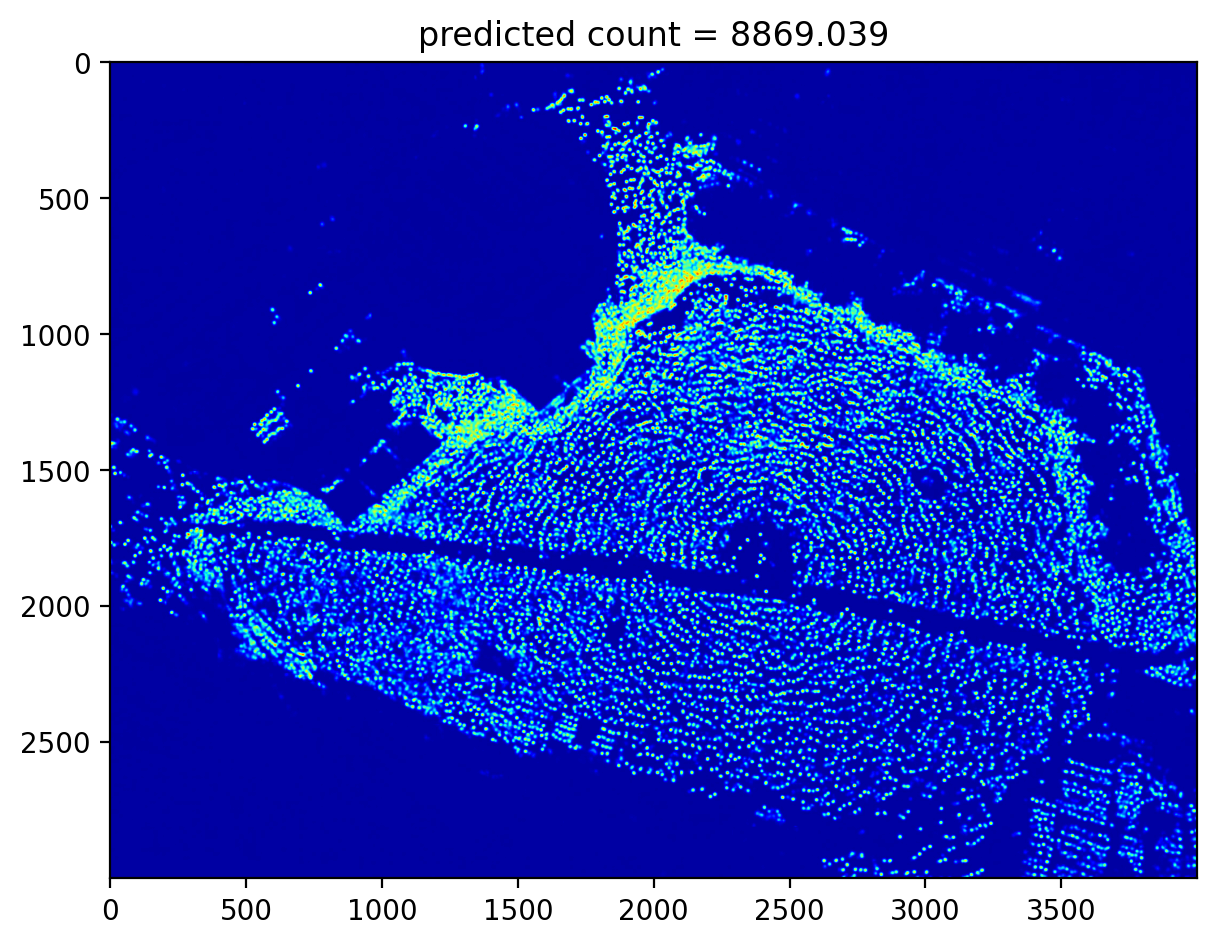

In [211]:
# Show model prediction
plt.figure(figsize=(1920/200, 1080/200), dpi=200)
plt.imshow(den, cmap=cm.jet)
plt.title(f'predicted count = {pred_cnt:.3f}')
plt.show()

## EXPERIMENTAL: Overlay the predicted density with the input image

Overlaps the predicted density map with the input image. To achieve this, we decrease the values in the 'red' and 'green' channels for pixels where the predicted density is above a certain threshold, and replace the values in the 'blue' channel with the normalised values of the predicted density map where those values exceed a given threshold.

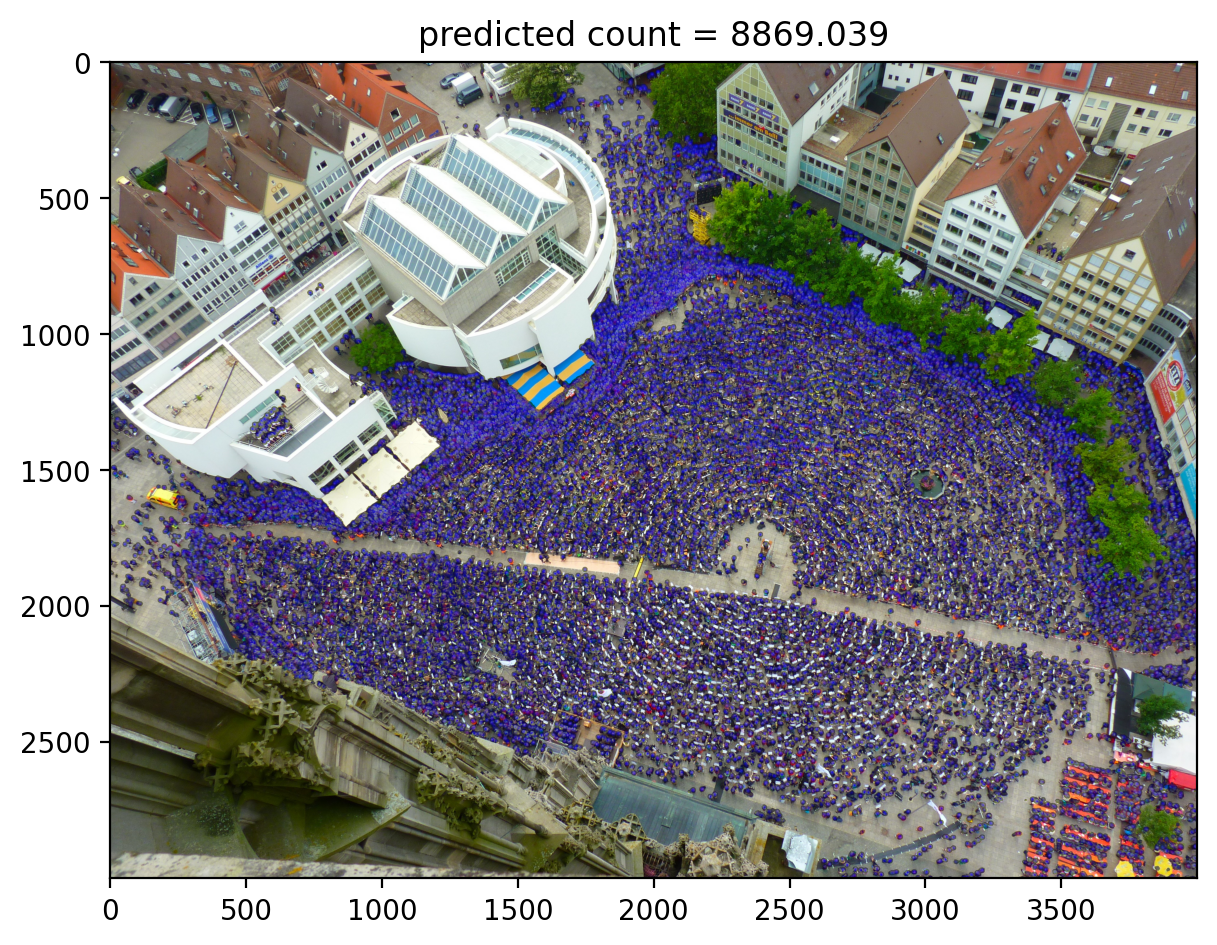

In [212]:
img_heat = np.array(input_image)
den_heat = den.clone().numpy()

den_heat = den_heat / 3000  # Scale values to original domain
den_heat[den_heat < 0] = 0  # Remove negative values
den_heat = den_heat / den_heat.max() # Normalise between 0 and 1

den_heat **= 0.5  # Reduce large values, increase small values
den_heat *= 255
den_heat[den_heat < 50] = 0

img_heat[:, :, 0][den_heat > 0] = img_heat[:, :, 0][den_heat > 0] / 2
img_heat[:, :, 1][den_heat > 0] = img_heat[:, :, 1][den_heat > 0] / 2
img_heat[:, :, 2][den_heat > 0] = den_heat[den_heat > 0]


plt.figure(figsize=(1920/200, 1080/200), dpi=200)
plt.imshow(img_heat)
plt.title(f'predicted count = {pred_cnt:.3f}')
plt.show()

## Save results if specified

In [213]:
# Save results if specified
if save_results:
    save_result_func(image_path, input_image, den, pred_cnt, img_heat)